In [1]:
import QUANTAXIS as QA
try:
    assert QA.__version__>='1.1.0'
except AssertionError:
    print('pip install QUANTAXIS >= 1.1.0 请升级QUANTAXIS后再运行此示例')
    import QUANTAXIS as QA 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import abupy
from abupy import ABuRegUtil
from concurrent.futures import ThreadPoolExecutor
from functools import reduce
import warnings

In [2]:
def amountAnalyse(buydata):
    """
    @buydata as pdDataFrame
    e.g. buydata = QA.QA_fetch_get_stock_transaction_realtime('pytdx','600797') get current day's transaction
    e.g. data1=QA.QAFetch.QATdx.QA_fetch_get_stock_transaction('600797','2019-01-01','2019-04-11') get transaction among period of time
    
    """
    sellone = buydata[buydata['buyorsell']==1]
    sellone['amount'] = sellone['price']*sellone['vol']
    sellone.sort_values("vol",inplace=True,ascending=False)

    buyone = buydata[buydata['buyorsell']==0]
    buyone['amount'] = buyone['price']*buyone['vol']
    buyone.sort_values("vol",inplace=True,ascending=False)
    #print("Top buyer vol")
    #buyone[buyone['vol']>10]
    print("Top Seller vol")
    sellone.head(100)
def getStocklist():
    """
    get all stock as list 
    usage as: 
    QA.QA_util_log_info('GET STOCK LIST')
    stocks=getStocklist()
    """
    data=QA.QAFetch.QATdx.QA_fetch_get_stock_list('stock')
    stock = data['code'].index
    stocklist = []
    for code in stock:
        stocklist.append(code[0])
    return stocklist
def loadLocalData(stocks,start_date ='2017-03-15',end_date = '2019-05-07'):
    """
    data() as pdDataFrame
    stocks could be list of all the stock or some. if you pass single one e.g. 000001 it will get one only
    to get dedicated stock, using below method, and notice stockp() will be dataFrame
    stockp = data.select_code(stock)
    
    
    """
    QA.QA_util_log_info('load data from local DB')
    data=QA.QA_fetch_stock_day_adv(stocks,start_date,end_date)
    return data
def loadFromCopy(file):
    """
    loaddata from file copy
    """
    return pd.DataFrame(pd.read_csv(file))

def calAngle(df):
    """
    trend angle based on provided dataframe 
    """
    return ABuRegUtil.calc_regress_deg(df.close.values,show=False)

def getData(df, code):
    """
    split data per code from all market data 
    """
    return df[df.code==code].reset_index(drop=True)

def trendBreak(pdDataFrame):
    """
    trendBreak based on provdied market data 
    """
   
    from abupy import pd_rolling_max
    from abupy import pd_expanding_max
    # 当天收盘价格超过N1天内最高价格作为买入信号
    N1 = 20
    # 当天收盘价格超过N2天内最低价格作为卖出信号
    N2 = 15
    kl_pd = pdDataFrame
    # 通过rolling_max方法计算最近N1个交易日的最高价
    # kl_pd['n1_high'] = pd.rolling_max(kl_pd['high'], window=N1)
    kl_pd['n1_high'] = pd_rolling_max(kl_pd['high'], window=N1)
    # 表7-4所示

    # expanding_max
    # expan_max = pd.expanding_max(kl_pd['close'])
    expan_max = pd_expanding_max(kl_pd['close'])
    # fillna使用序列对应的expan_max
    kl_pd['n1_high'].fillna(value=expan_max, inplace=True)
    # 表7-5所示
    #print('kl_pd[0:5]:\n', kl_pd[0:5])

    from abupy import pd_rolling_min, pd_expanding_min
    # 通过rolling_min方法计算最近N2个交易日的最低价格
    # rolling_min与rolling_max类似
    # kl_pd['n2_low'] = pd.rolling_min(kl_pd['low'], window=N2)
    kl_pd['n2_low'] = pd_rolling_min(kl_pd['low'], window=N2)
    # expanding_min与expanding_max类似
    # expan_min = pd.expanding_min(kl_pd['close'])
    expan_min = pd_expanding_min(kl_pd['close'])
    # fillna使用序列对应的eexpan_min
    kl_pd['n2_low'].fillna(value=expan_min, inplace=True)

    # 当天收盘价格超过N天内的最高价或最低价, 超过最高价格作为买入信号买入股票持有
    buy_index = kl_pd[kl_pd['close'] > kl_pd['n1_high'].shift(1)].index
    kl_pd.loc[buy_index, 'signal'] = 1

    # 当天收盘价格超过N天内的最高价或最低价, 超过最低价格作为卖出信号
    sell_index = kl_pd[kl_pd['close'] < kl_pd['n2_low'].shift(1)].index
    kl_pd.loc[sell_index, 'signal'] = 0

    #kl_pd.signal.value_counts().plot(kind='pie', figsize=(5, 5))
    #plt.show()

    """
        将信号操作序列移动一个单位，代表第二天再将操作信号执行，转换得到持股状态
        这里不shift(1)也可以，代表信号产生当天执行，但是由于收盘价格是在收盘后
        才确定的，计算突破使用了收盘价格，所以使用shift(1)更接近真实情况
    """
    kl_pd['keep'] = kl_pd['signal'].shift(1)
    kl_pd['keep'].fillna(method='ffill', inplace=True)
    return kl_pd

    # 计算基准收益
    #kl_pd['benchmark_profit'] = np.log(
        #kl_pd['close'] / kl_pd['close'].shift(1))

    # 计算使用趋势突破策略的收益
    #kl_pd['trend_profit'] = kl_pd['keep'] * kl_pd['benchmark_profit']

    # 可视化收益的情况对比
    #kl_pd[['benchmark_profit', 'trend_profit']].cumsum().plot(grid=True,
        #                                                      figsize=(
        #                                                          14, 7))
    #plt.show()
    #kl_pd[['n2_low','n1_high','close']].plot(grid=True,figsize=(14,7))
    #kl_pd.close.plot(grid=True,figsize=(14.7))
    #plt.show()

def execute(stocks,data): 
    select=[]
    for stock in stocks: 
        try:
            QA.QA_util_log_info('dealting with {}'.format(stock))
            stockp = data.select_code(stock)
            if (trend(stockp[-10:])>0 and trend(stockp[-10:])<10):
                select.append(stock)
        except:
            print('wrong with {}'.format(stock))

    return sorted(select)[-2:]


def executeParallel(stocks,data): 
    """
    scan all data and filter out ones doing trendbreak
    """
    alldep=[]
    with ThreadPoolExecutor(5) as executor:
        for stock , dep in zip(stocks,executor.map(trendSingle,alldata)):
            alldep.append((stock,dep))
    print('all done')          
    return alldep
def init_change(df):
    #change first (d[i].close-d[i-1].close)/d[i-1].close
    pp_array = [float(close) for close in df.close]
    temp_array = [(price1, price2) for price1,price2 in zip(pp_array[:-1],pp_array[1:])]
    change = list(map(lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp), temp_array))
    change.insert(0,0)
    df['change'] = change
    #amplitude (d[i].high-d[i].low)/d[i-1].close) 
    amp_arry=[float(amp) for amp in (df.high-df.low)]
    amp_temp =  [(price1, price2) for price1,price2 in zip(amp_arry[:-1],pp_array[1:])]
    amplitude = list(map(lambda pp: reduce(lambda a, b: round(a/b, 3), pp), amp_temp))
    amplitude.insert(0,0)
    df['amplitude'] = amplitude
    
def init_trend(df,period=7):
    """
    period can be set based on situation. 
    detect the angle change form negative to positive 
    """
    trend=[]
    ratio = []
    for i in range(0,df.shape[0]):
        #print(i)
        if(i<period):
            trend.append(calAngle(df.iloc[:period]))
            ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
        else:
            trend.append(calAngle(df.iloc[i-period+1:i+1]))
            ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
    df['trend']=trend
    df['amountRatio'] = ratio
"""

def trendSingle(df):
   
    buydate=[]
    for i in range(0,df.shape[0]):
        if(df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude<0.07 and df.iloc[i].change<0.03 
          and df.iloc[i].change>0.01):
            buydate.append((i,df.iloc[i].date))
    return buydate
"""

def trendSingle(df):
    """
    @paramater dataframe 
    return True or False
    Justification:
    1. latest 20 days angle >0
    2. chagne (0.1~0.3)
    3. 
    
    """
    keep = 3
    init_change(df)
    init_trend(df)
    single=[]
    for i in range(0,df.shape[0]):
        if(df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude>0.07 and 0.01<df.iloc[i].change<0.03):
            single.append(1)
        else:
            single.append(0)
    for i in range(0,len(single)):
        if single[i] == 1:
            #set the sell date
            keep = 3
            j = i 
            while(keep):
                if j+1<len(single) and df.iloc[j+1].close<df.iloc[j].close:
                #drop then sell
                    single[j+1]=3
                    break
                elif j+1 < len(single) and df.iloc[j+1].close >df.iloc[j].close:
                    single[j+1] = 0  # if keep the changel also the possible buy to 0 
                #raise then keep one more day
                
                    keep -=1 
                    j = j + 1
            if(keep == 0):
                single[i+3] = 3    
    df['single']=single
    return df

def detect(df): 
    init_change(df)
    init_trend(df)
    if(df.iloc[-1].amountRatio>1 and df.iloc[-1].trend>1 and df.iloc[-1].amplitude>0.07 and 0.01<df.iloc[-1].change<0.03):
        return True
    else: 
        return False 

In [3]:
    codelist3 = QA.QA_fetch_stock_block_adv().get_block('云计算').code[:]
    codelist1 = QA.QA_fetch_stock_block_adv().get_block('华为概念').code[:]
    codelist2 = QA.QA_fetch_stock_block_adv().get_block('5G概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    codelist1.extend(codelist2)
    codelist1.extend(codelist3)

    #
    clist3 = QA.QA_fetch_stock_block_adv().get_block('阿里概念').code[:]
    clist1 = QA.QA_fetch_stock_block_adv().get_block('腾讯概念').code[:]
    clist2 = QA.QA_fetch_stock_block_adv().get_block('小米概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    clist1.extend(clist2)
    clist1.extend(clist3)

    # codelist1.extend(codelist4)
    codelist = list(set(codelist1))


In [11]:
for i in codelist:
    code = i
    print( QA.QA_fetch_get_stock_info('pytdx',i).liutongguben[0])

QUANTAXIS>> Selecting the Best Server IP of TDX
Selecting the Best Server IP of TDX


USING DEFAULT STOCK IP
USING DEFAULT FUTURE IP


QUANTAXIS>> === The BEST SERVER ===
 stock_ip 112.95.140.93 future_ip 59.175.238.38
=== The BEST SERVER ===
 stock_ip 112.95.140.93 future_ip 59.175.238.38


268376699.21875
1510445156.25
2393360468.75
366436796.875
2544900000.0
996432968.75
2807608125.0
437020390.625
7464400625.0
33523999.0234375
200885000.0
216276406.25
102436601.5625
2963899062.5
997284765.625
1828920468.75
379624609.375
87099199.21875
416532382.8125
610161601.5625
2206771718.75
1342879843.75
646422500.0
118039101.5625
174033496.09375
513688007.8125
453227304.6875
839135468.75
232688105.46875
187090898.4375
340910195.3125
543720000.0
107127001.953125
332285390.625
133049697.265625
14513000.48828125
510331289.0625
373788085.9375
99052802.734375
307960292.96875
596336210.9375
648414882.8125
1176510937.5
998433906.25
83920703.125
192271406.25
1033464687.5
51000000.0
205243691.40625
49608999.0234375
1391777812.5
162299003.90625
229455996.09375
2781020937.5
764516328.125
929597968.75
59041000.9765625
21668798.828125
789769531.25
106573496.09375
296950292.96875
113626298.828125
179301796.875
610094492.1875
723371328.125
105407998.046875
441295507.8125
165733691.40625
40020400.

In [22]:
QA.QA_fetch_get_stock_info('000977').liutongguben[0]

1289252187.5

In [12]:
liutongDict ={}
for item in codelist:
    try: 
        print("getting info for {}".format(item))
        sratio = QA.QA_fetch_get_stock_info('pytdx',item).liutongguben[0]
        liutongDict[item] = sratio
    except: 
        print("wrong with "+ item)


    

getting info for 603936
getting info for 600496
getting info for 002152
getting info for 603712
getting info for 601928
getting info for 300325
getting info for 002065
getting info for 300279
getting info for 000629
getting info for 300710
getting info for 300634
getting info for 300218
getting info for 300738
getting info for 600100
getting info for 300297
getting info for 000050
getting info for 000890
getting info for 300615
getting info for 603003
getting info for 600114
getting info for 002075
getting info for 002542
getting info for 002182
getting info for 300537
getting info for 300579
getting info for 300212
getting info for 000925
getting info for 300367
getting info for 300379
getting info for 300468
getting info for 600767
getting info for 600353
getting info for 300678
getting info for 300366
getting info for 002796
getting info for 688228
getting info for 300047
getting info for 300036
getting info for 300691
getting info for 300245
getting info for 300188
getting info for

getting info for 688369
getting info for 002436
getting info for 300778
getting info for 300458
getting info for 300128
getting info for 600677
getting info for 000158
getting info for 600360
getting info for 002681
getting info for 600703
getting info for 300344
getting info for 600797
getting info for 002090
getting info for 300136
getting info for 300545
getting info for 603918
getting info for 600728
getting info for 300354
getting info for 300229
getting info for 688023
getting info for 603882
getting info for 002202
getting info for 002194
getting info for 002955
getting info for 300351
getting info for 002706
getting info for 000586
getting info for 002642
getting info for 002055
getting info for 002288
getting info for 000836
getting info for 688058
getting info for 002315
getting info for 002369
getting info for 600498
getting info for 600206
getting info for 300566
getting info for 002137
getting info for 300560
getting info for 300074
getting info for 002093
getting info for

In [13]:
import numpy as np
np.save('liutong.npy',liutongDict)

In [14]:
read_dictionary = np.load('liutong.npy',allow_pickle=True).item()

In [15]:
read_dictionary['000977']

1441117968.75

In [4]:
m = QA.QAFetch.QATdx.QA_fetch_get_stock_block().blockname

In [14]:
block = []
for item in m:
    block.append(item)
for key in set(block):
    print (key)

奢侈品
近期新高
油气改革
上证180
国证商业
华为概念
巨潮地产
创业创新
中华A80
高校背景
高质押股
三网融合
破净资产
高端装备
无人机
深证治理
氟概念
养老概念
民企100
次新开板
PPP模式
蓝宝石
创业蓝筹
铁路基建
保障房
国证治理
壳资源
银河99
智能穿戴
亏损股
资源优势
信托重仓
昨曾涨停
可燃冰
昨日振荡
保险重仓
最近闪崩
工业互联
国证成长
民营医院
低市盈率
定增股
水利建设
次新超跌
新零售
百元股
300非周
昨日首板
小盘成长
建筑节能
风能
新能源车
上周强势
长三角
中证龙头
超清视频
长株潭
跨境电商
免疫治疗
东亚自贸
两年新股
MSCI中盘
全息概念
食品安全
大盘股
大数据i
上证红利
定增预案
含H股
国证价值
国证服务
稀土永磁
腾讯概念
近期异动
涉矿概念
赛马概念
种业
土地流转
工业大麻
上海自贸
朝鲜改革
中证200
昨日涨停
农村金融
虚拟现实
行业龙头
成渝特区
参股金融
抗流感
信息安全
智能电视
无人驾驶
拟减持
基金重仓
知识产权
社保重仓
物联网
融资融券
深证价值
国开持股
国证红利
证金持股
多晶硅
皖江区域
石墨烯
3D打印
太阳能
业绩预降
微利股
中盘成长
污水处理
国防军工
国证农业
能源互联
QFII新进
昨日较弱
卫星导航
摘帽
昨高换手
碳纤维
小盘价值
装饰园林
中小银行
在线教育
维生素
次新股
央企改革
融资增加
最近多板
绿色照明
重组预案
腾讯济安
预高送转
罗素小盘
海峡西岸
昨日较强
上证创新
陆股通买
养老金
安防服务
芯片
户数减少
风险提示
QFII重仓
含B股
中小板指
阿里概念
云计算
百度概念
分散染料
创业板50
特钢
通达信88
钛金属
大盘成长
上证超大
大数据
高股息股
个人持股
高贝塔值
人工智能
次新预增
草甘膦
中证央企
陆股通卖
一带一路
婴童概念
智能医疗
光刻机
国证基建
创投概念
高管增持
特斯拉
业绩预升
创业大盘
拟增持
海水淡化
智能交通
绩优股
国证大宗
要约收购
央企100
整体上市
罗素大盘
重组股
租购同权
保险新进
员工持股
新硬件
节能
券商重仓
送转超跌
抗癌
高市盈率
OLED概念
上证治理
上证380
上周弱势
国产软件
苹果概念
上证中盘
雄安新区
近期解禁
低市净率
外资背景
深证成指
民营银

In [492]:
stockes = getStocklist()
data = loadLocalData(stockes,'2017-03-15',end_date = '2019-09-11')


QUANTAXIS>> load data from local DB
load data from local DB


In [494]:
type(data.select_code('600797').data)

pandas.core.frame.DataFrame

In [495]:
select=[]
for stock in stockes: 
    try:
        QA.QA_util_log_info('dealting with {}'.format(stock))
        stockp = data.select_code(stock)
        if (detect(stockp.data)):
            select.append(stock)
    except:
        print('wrong with {}'.format(stock))


QUANTAXIS>> dealting with 000001
dealting with 000001
QUANTAXIS>> dealting with 000002
dealting with 000002
QUANTAXIS>> dealting with 000004
dealting with 000004
QUANTAXIS>> dealting with 000005
dealting with 000005
QUANTAXIS>> dealting with 000006
dealting with 000006
QUANTAXIS>> dealting with 000007
dealting with 000007
QUANTAXIS>> dealting with 000008
dealting with 000008
QUANTAXIS>> dealting with 000009
dealting with 000009
QUANTAXIS>> dealting with 000010
dealting with 000010
QUANTAXIS>> dealting with 000011
dealting with 000011
QUANTAXIS>> dealting with 000012
dealting with 000012
QUANTAXIS>> dealting with 000014
dealting with 000014
QUANTAXIS>> dealting with 000016
dealting with 000016
QUANTAXIS>> dealting with 000017
dealting with 000017
QUANTAXIS>> dealting with 000018
dealting with 000018
QUANTAXIS>> dealting with 000019
dealting with 000019
QUANTAXIS>> dealting with 000020
dealting with 000020
QUANTAXIS>> dealting with 000021
dealting with 000021
QUANTAXIS>> dealting with 00

wrong with 000029


QUANTAXIS>> dealting with 000030
dealting with 000030
QUANTAXIS>> dealting with 000031
dealting with 000031
QUANTAXIS>> dealting with 000032
dealting with 000032
QUANTAXIS>> dealting with 000034
dealting with 000034
QUANTAXIS>> dealting with 000035
dealting with 000035
QUANTAXIS>> dealting with 000036
dealting with 000036
QUANTAXIS>> dealting with 000037
dealting with 000037
QUANTAXIS>> dealting with 000038
dealting with 000038
QUANTAXIS>> dealting with 000039
dealting with 000039
QUANTAXIS>> dealting with 000040
dealting with 000040
QUANTAXIS>> dealting with 000042
dealting with 000042
QUANTAXIS>> dealting with 000043
dealting with 000043
QUANTAXIS>> dealting with 000045
dealting with 000045
QUANTAXIS>> dealting with 000046
dealting with 000046
QUANTAXIS>> dealting with 000048
dealting with 000048
QUANTAXIS>> dealting with 000049
dealting with 000049
QUANTAXIS>> dealting with 000050
dealting with 000050
QUANTAXIS>> dealting with 000055
dealting with 000055
QUANTAXIS>> dealting with 00

QUANTAXIS>> dealting with 000815
dealting with 000815
QUANTAXIS>> dealting with 000816
dealting with 000816
QUANTAXIS>> dealting with 000818
dealting with 000818
QUANTAXIS>> dealting with 000819
dealting with 000819
QUANTAXIS>> dealting with 000820
dealting with 000820
QUANTAXIS>> dealting with 000821
dealting with 000821
QUANTAXIS>> dealting with 000822
dealting with 000822
QUANTAXIS>> dealting with 000823
dealting with 000823
QUANTAXIS>> dealting with 000825
dealting with 000825
QUANTAXIS>> dealting with 000826
dealting with 000826
QUANTAXIS>> dealting with 000828
dealting with 000828
QUANTAXIS>> dealting with 000829
dealting with 000829
QUANTAXIS>> dealting with 000830
dealting with 000830
QUANTAXIS>> dealting with 000831
dealting with 000831
QUANTAXIS>> dealting with 000833
dealting with 000833
QUANTAXIS>> dealting with 000835
dealting with 000835
QUANTAXIS>> dealting with 000836
dealting with 000836
QUANTAXIS>> dealting with 000837
dealting with 000837
QUANTAXIS>> dealting with 00

QUANTAXIS>> dealting with 002171
dealting with 002171
QUANTAXIS>> dealting with 002172
dealting with 002172
QUANTAXIS>> dealting with 002173
dealting with 002173
QUANTAXIS>> dealting with 002174
dealting with 002174
QUANTAXIS>> dealting with 002175
dealting with 002175
QUANTAXIS>> dealting with 002176
dealting with 002176
QUANTAXIS>> dealting with 002177
dealting with 002177
QUANTAXIS>> dealting with 002178
dealting with 002178
QUANTAXIS>> dealting with 002179
dealting with 002179
QUANTAXIS>> dealting with 002180
dealting with 002180
QUANTAXIS>> dealting with 002181
dealting with 002181
QUANTAXIS>> dealting with 002182
dealting with 002182
QUANTAXIS>> dealting with 002183
dealting with 002183
QUANTAXIS>> dealting with 002184
dealting with 002184
QUANTAXIS>> dealting with 002185
dealting with 002185
QUANTAXIS>> dealting with 002186
dealting with 002186
QUANTAXIS>> dealting with 002187
dealting with 002187
QUANTAXIS>> dealting with 002188
dealting with 002188
QUANTAXIS>> dealting with 00

QUANTAXIS>> dealting with 002475
dealting with 002475
QUANTAXIS>> dealting with 002476
dealting with 002476
QUANTAXIS>> dealting with 002477
dealting with 002477
QUANTAXIS>> dealting with 002478
dealting with 002478
QUANTAXIS>> dealting with 002479
dealting with 002479
QUANTAXIS>> dealting with 002480
dealting with 002480
QUANTAXIS>> dealting with 002481
dealting with 002481
QUANTAXIS>> dealting with 002482
dealting with 002482
QUANTAXIS>> dealting with 002483
dealting with 002483
QUANTAXIS>> dealting with 002484
dealting with 002484
QUANTAXIS>> dealting with 002485
dealting with 002485
QUANTAXIS>> dealting with 002486
dealting with 002486
QUANTAXIS>> dealting with 002487
dealting with 002487
QUANTAXIS>> dealting with 002488
dealting with 002488
QUANTAXIS>> dealting with 002489
dealting with 002489
QUANTAXIS>> dealting with 002490
dealting with 002490
QUANTAXIS>> dealting with 002491
dealting with 002491
QUANTAXIS>> dealting with 002492
dealting with 002492
QUANTAXIS>> dealting with 00

QUANTAXIS>> dealting with 002786
dealting with 002786
QUANTAXIS>> dealting with 002787
dealting with 002787
QUANTAXIS>> dealting with 002788
dealting with 002788
QUANTAXIS>> dealting with 002789
dealting with 002789
QUANTAXIS>> dealting with 002790
dealting with 002790
QUANTAXIS>> dealting with 002791
dealting with 002791
QUANTAXIS>> dealting with 002792
dealting with 002792
QUANTAXIS>> dealting with 002793
dealting with 002793
QUANTAXIS>> dealting with 002795
dealting with 002795
QUANTAXIS>> dealting with 002796
dealting with 002796
QUANTAXIS>> dealting with 002797
dealting with 002797
QUANTAXIS>> dealting with 002798
dealting with 002798
QUANTAXIS>> dealting with 002799
dealting with 002799
QUANTAXIS>> dealting with 002800
dealting with 002800
QUANTAXIS>> dealting with 002801
dealting with 002801
QUANTAXIS>> dealting with 002802
dealting with 002802
QUANTAXIS>> dealting with 002803
dealting with 002803
QUANTAXIS>> dealting with 002805
dealting with 002805
QUANTAXIS>> dealting with 00

wrong with 002962


QUANTAXIS>> dealting with 002966
dealting with 002966
QUANTAXIS>> dealting with 003816
dealting with 003816
QUANTAXIS>> dealting with 300001
dealting with 300001
QUANTAXIS>> dealting with 300002
dealting with 300002
QUANTAXIS>> dealting with 300003
dealting with 300003
QUANTAXIS>> dealting with 300004
dealting with 300004
QUANTAXIS>> dealting with 300005
dealting with 300005
QUANTAXIS>> dealting with 300006
dealting with 300006
QUANTAXIS>> dealting with 300007
dealting with 300007
QUANTAXIS>> dealting with 300008
dealting with 300008
QUANTAXIS>> dealting with 300009
dealting with 300009
QUANTAXIS>> dealting with 300010
dealting with 300010
QUANTAXIS>> dealting with 300011
dealting with 300011
QUANTAXIS>> dealting with 300012
dealting with 300012
QUANTAXIS>> dealting with 300013
dealting with 300013
QUANTAXIS>> dealting with 300014
dealting with 300014
QUANTAXIS>> dealting with 300015
dealting with 300015
QUANTAXIS>> dealting with 300016
dealting with 300016
QUANTAXIS>> dealting with 30

QUANTAXIS>> dealting with 300304
dealting with 300304
QUANTAXIS>> dealting with 300305
dealting with 300305
QUANTAXIS>> dealting with 300306
dealting with 300306
QUANTAXIS>> dealting with 300307
dealting with 300307
QUANTAXIS>> dealting with 300308
dealting with 300308
QUANTAXIS>> dealting with 300309
dealting with 300309
QUANTAXIS>> dealting with 300310
dealting with 300310
QUANTAXIS>> dealting with 300311
dealting with 300311
QUANTAXIS>> dealting with 300312
dealting with 300312
QUANTAXIS>> dealting with 300313
dealting with 300313
QUANTAXIS>> dealting with 300314
dealting with 300314
QUANTAXIS>> dealting with 300315
dealting with 300315
QUANTAXIS>> dealting with 300316
dealting with 300316
QUANTAXIS>> dealting with 300317
dealting with 300317
QUANTAXIS>> dealting with 300318
dealting with 300318
QUANTAXIS>> dealting with 300319
dealting with 300319
QUANTAXIS>> dealting with 300320
dealting with 300320
QUANTAXIS>> dealting with 300321
dealting with 300321
QUANTAXIS>> dealting with 30

QUANTAXIS>> dealting with 300613
dealting with 300613
QUANTAXIS>> dealting with 300615
dealting with 300615
QUANTAXIS>> dealting with 300616
dealting with 300616
QUANTAXIS>> dealting with 300617
dealting with 300617
QUANTAXIS>> dealting with 300618
dealting with 300618
QUANTAXIS>> dealting with 300619
dealting with 300619
QUANTAXIS>> dealting with 300620
dealting with 300620
QUANTAXIS>> dealting with 300621
dealting with 300621
QUANTAXIS>> dealting with 300622
dealting with 300622
QUANTAXIS>> dealting with 300623
dealting with 300623
QUANTAXIS>> dealting with 300624
dealting with 300624
QUANTAXIS>> dealting with 300625
dealting with 300625
QUANTAXIS>> dealting with 300626
dealting with 300626
QUANTAXIS>> dealting with 300627
dealting with 300627
QUANTAXIS>> dealting with 300628
dealting with 300628
QUANTAXIS>> dealting with 300629
dealting with 300629
QUANTAXIS>> dealting with 300630
dealting with 300630
QUANTAXIS>> dealting with 300631
dealting with 300631
QUANTAXIS>> dealting with 30

wrong with 300790


QUANTAXIS>> dealting with 300791
dealting with 300791


wrong with 300791


QUANTAXIS>> dealting with 600000
dealting with 600000
QUANTAXIS>> dealting with 600004
dealting with 600004
QUANTAXIS>> dealting with 600006
dealting with 600006
QUANTAXIS>> dealting with 600007
dealting with 600007
QUANTAXIS>> dealting with 600008
dealting with 600008
QUANTAXIS>> dealting with 600009
dealting with 600009
QUANTAXIS>> dealting with 600010
dealting with 600010
QUANTAXIS>> dealting with 600011
dealting with 600011
QUANTAXIS>> dealting with 600012
dealting with 600012
QUANTAXIS>> dealting with 600015
dealting with 600015
QUANTAXIS>> dealting with 600016
dealting with 600016
QUANTAXIS>> dealting with 600017
dealting with 600017
QUANTAXIS>> dealting with 600018
dealting with 600018
QUANTAXIS>> dealting with 600019
dealting with 600019
QUANTAXIS>> dealting with 600020
dealting with 600020
QUANTAXIS>> dealting with 600021
dealting with 600021
QUANTAXIS>> dealting with 600022
dealting with 600022
QUANTAXIS>> dealting with 600023
dealting with 600023
QUANTAXIS>> dealting with 60

wrong with 600145


QUANTAXIS>> dealting with 600146
dealting with 600146
QUANTAXIS>> dealting with 600148
dealting with 600148
QUANTAXIS>> dealting with 600149
dealting with 600149
QUANTAXIS>> dealting with 600150
dealting with 600150
QUANTAXIS>> dealting with 600151
dealting with 600151
QUANTAXIS>> dealting with 600152
dealting with 600152
QUANTAXIS>> dealting with 600153
dealting with 600153
QUANTAXIS>> dealting with 600155
dealting with 600155
QUANTAXIS>> dealting with 600156
dealting with 600156
QUANTAXIS>> dealting with 600157
dealting with 600157
QUANTAXIS>> dealting with 600158
dealting with 600158
QUANTAXIS>> dealting with 600159
dealting with 600159
QUANTAXIS>> dealting with 600160
dealting with 600160
QUANTAXIS>> dealting with 600161
dealting with 600161
QUANTAXIS>> dealting with 600162
dealting with 600162
QUANTAXIS>> dealting with 600163
dealting with 600163
QUANTAXIS>> dealting with 600165
dealting with 600165
QUANTAXIS>> dealting with 600166
dealting with 600166
QUANTAXIS>> dealting with 60

QUANTAXIS>> dealting with 600522
dealting with 600522
QUANTAXIS>> dealting with 600523
dealting with 600523
QUANTAXIS>> dealting with 600525
dealting with 600525
QUANTAXIS>> dealting with 600526
dealting with 600526
QUANTAXIS>> dealting with 600527
dealting with 600527
QUANTAXIS>> dealting with 600528
dealting with 600528
QUANTAXIS>> dealting with 600529
dealting with 600529
QUANTAXIS>> dealting with 600530
dealting with 600530
QUANTAXIS>> dealting with 600531
dealting with 600531
QUANTAXIS>> dealting with 600532
dealting with 600532
QUANTAXIS>> dealting with 600533
dealting with 600533
QUANTAXIS>> dealting with 600535
dealting with 600535
QUANTAXIS>> dealting with 600536
dealting with 600536
QUANTAXIS>> dealting with 600537
dealting with 600537
QUANTAXIS>> dealting with 600538
dealting with 600538
QUANTAXIS>> dealting with 600539
dealting with 600539
QUANTAXIS>> dealting with 600540
dealting with 600540
QUANTAXIS>> dealting with 600543
dealting with 600543
QUANTAXIS>> dealting with 60

QUANTAXIS>> dealting with 600862
dealting with 600862
QUANTAXIS>> dealting with 600863
dealting with 600863
QUANTAXIS>> dealting with 600864
dealting with 600864
QUANTAXIS>> dealting with 600865
dealting with 600865
QUANTAXIS>> dealting with 600866
dealting with 600866
QUANTAXIS>> dealting with 600867
dealting with 600867
QUANTAXIS>> dealting with 600868
dealting with 600868
QUANTAXIS>> dealting with 600869
dealting with 600869
QUANTAXIS>> dealting with 600870
dealting with 600870
QUANTAXIS>> dealting with 600871
dealting with 600871
QUANTAXIS>> dealting with 600872
dealting with 600872
QUANTAXIS>> dealting with 600873
dealting with 600873
QUANTAXIS>> dealting with 600874
dealting with 600874
QUANTAXIS>> dealting with 600875
dealting with 600875
QUANTAXIS>> dealting with 600876
dealting with 600876
QUANTAXIS>> dealting with 600877
dealting with 600877
QUANTAXIS>> dealting with 600879
dealting with 600879
QUANTAXIS>> dealting with 600880
dealting with 600880
QUANTAXIS>> dealting with 60

wrong with 601077


QUANTAXIS>> dealting with 601086
dealting with 601086
QUANTAXIS>> dealting with 601088
dealting with 601088
QUANTAXIS>> dealting with 601098
dealting with 601098
QUANTAXIS>> dealting with 601099
dealting with 601099
QUANTAXIS>> dealting with 601100
dealting with 601100
QUANTAXIS>> dealting with 601101
dealting with 601101
QUANTAXIS>> dealting with 601106
dealting with 601106
QUANTAXIS>> dealting with 601107
dealting with 601107
QUANTAXIS>> dealting with 601108
dealting with 601108
QUANTAXIS>> dealting with 601111
dealting with 601111
QUANTAXIS>> dealting with 601113
dealting with 601113
QUANTAXIS>> dealting with 601116
dealting with 601116
QUANTAXIS>> dealting with 601117
dealting with 601117
QUANTAXIS>> dealting with 601118
dealting with 601118
QUANTAXIS>> dealting with 601126
dealting with 601126
QUANTAXIS>> dealting with 601127
dealting with 601127
QUANTAXIS>> dealting with 601128
dealting with 601128
QUANTAXIS>> dealting with 601137
dealting with 601137
QUANTAXIS>> dealting with 60

QUANTAXIS>> dealting with 603239
dealting with 603239
QUANTAXIS>> dealting with 603256
dealting with 603256
QUANTAXIS>> dealting with 603258
dealting with 603258
QUANTAXIS>> dealting with 603259
dealting with 603259
QUANTAXIS>> dealting with 603260
dealting with 603260
QUANTAXIS>> dealting with 603266
dealting with 603266
QUANTAXIS>> dealting with 603267
dealting with 603267
QUANTAXIS>> dealting with 603268
dealting with 603268
QUANTAXIS>> dealting with 603269
dealting with 603269
QUANTAXIS>> dealting with 603277
dealting with 603277
QUANTAXIS>> dealting with 603278
dealting with 603278
QUANTAXIS>> dealting with 603279
dealting with 603279
QUANTAXIS>> dealting with 603283
dealting with 603283
QUANTAXIS>> dealting with 603286
dealting with 603286
QUANTAXIS>> dealting with 603288
dealting with 603288
QUANTAXIS>> dealting with 603289
dealting with 603289
QUANTAXIS>> dealting with 603297
dealting with 603297
QUANTAXIS>> dealting with 603298
dealting with 603298
QUANTAXIS>> dealting with 60

wrong with 603786


QUANTAXIS>> dealting with 603787
dealting with 603787
QUANTAXIS>> dealting with 603788
dealting with 603788
QUANTAXIS>> dealting with 603789
dealting with 603789
QUANTAXIS>> dealting with 603790
dealting with 603790
QUANTAXIS>> dealting with 603797
dealting with 603797
QUANTAXIS>> dealting with 603798
dealting with 603798
QUANTAXIS>> dealting with 603799
dealting with 603799
QUANTAXIS>> dealting with 603800
dealting with 603800
QUANTAXIS>> dealting with 603801
dealting with 603801
QUANTAXIS>> dealting with 603803
dealting with 603803
QUANTAXIS>> dealting with 603806
dealting with 603806
QUANTAXIS>> dealting with 603808
dealting with 603808
QUANTAXIS>> dealting with 603809
dealting with 603809
QUANTAXIS>> dealting with 603810
dealting with 603810
QUANTAXIS>> dealting with 603811
dealting with 603811
QUANTAXIS>> dealting with 603813
dealting with 603813
QUANTAXIS>> dealting with 603815
dealting with 603815


wrong with 603815


QUANTAXIS>> dealting with 603816
dealting with 603816
QUANTAXIS>> dealting with 603817
dealting with 603817
QUANTAXIS>> dealting with 603818
dealting with 603818
QUANTAXIS>> dealting with 603819
dealting with 603819
QUANTAXIS>> dealting with 603822
dealting with 603822
QUANTAXIS>> dealting with 603823
dealting with 603823
QUANTAXIS>> dealting with 603825
dealting with 603825
QUANTAXIS>> dealting with 603826
dealting with 603826
QUANTAXIS>> dealting with 603828
dealting with 603828
QUANTAXIS>> dealting with 603829
dealting with 603829
QUANTAXIS>> dealting with 603833
dealting with 603833
QUANTAXIS>> dealting with 603838
dealting with 603838
QUANTAXIS>> dealting with 603839
dealting with 603839
QUANTAXIS>> dealting with 603843
dealting with 603843
QUANTAXIS>> dealting with 603848
dealting with 603848
QUANTAXIS>> dealting with 603855
dealting with 603855
QUANTAXIS>> dealting with 603856
dealting with 603856
QUANTAXIS>> dealting with 603858
dealting with 603858
QUANTAXIS>> dealting with 60

wrong with 688030


QUANTAXIS>> dealting with 688033
dealting with 688033
QUANTAXIS>> dealting with 688036
dealting with 688036


wrong with 688036


QUANTAXIS>> dealting with 688066
dealting with 688066
QUANTAXIS>> dealting with 688068
dealting with 688068


wrong with 688068


QUANTAXIS>> dealting with 688088
dealting with 688088
QUANTAXIS>> dealting with 688099
dealting with 688099
QUANTAXIS>> dealting with 688116
dealting with 688116


wrong with 688116


QUANTAXIS>> dealting with 688122
dealting with 688122
QUANTAXIS>> dealting with 688168
dealting with 688168
QUANTAXIS>> dealting with 688188
dealting with 688188
QUANTAXIS>> dealting with 688321
dealting with 688321
QUANTAXIS>> dealting with 688333
dealting with 688333
QUANTAXIS>> dealting with 688388
dealting with 688388


In [496]:
select

['000534',
 '000910',
 '002537',
 '002565',
 '002575',
 '002876',
 '300105',
 '300194',
 '300464',
 '300492',
 '600599',
 '600843',
 '603998']

In [497]:
Account=QA.QA_Account(user_cookie='eric',portfolio_cookie='eric')
Broker=QA.QA_BacktestBroker()
Account.message

QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE
QAACCOUNT: THIS ACCOUNT DOESNOT HAVE ANY TRADE


{'account_cookie': 'Acc_uw3M2Wrb',
 'allow_sellopen': False,
 'allow_t0': False,
 'broker': 'backtest',
 'cash': [1000000],
 'commission_coeff': 0.00025,
 'current_time': 'None',
 'end_date': None,
 'frequence': 'day',
 'history': [],
 'init_assets': {'cash': 1000000, 'hold': {}},
 'init_cash': 1000000,
 'init_hold': {},
 'margin_level': {},
 'market_type': 'stock_cn',
 'portfolio_cookie': 'eric',
 'quantaxis_version': '1.3.0.dev13',
 'running_environment': 'backtest',
 'running_time': '2019-09-12 07:17:44.472678',
 'source': 'account',
 'start_date': None,
 'strategy_name': None,
 'tax_coeff': 0.001,
 'trade_index': [],
 'user_cookie': 'eric'}

In [498]:
Account.reset_assets(50000)
Account.account_cookie='ERICCAPTITAL'

In [586]:
code = getStocklist()
with open('stock.csv','w') as f: 
    for co in code:
        f.write(co)
#candidate = ['601068','601069','000977']
candidate = ['000910']

In [587]:
codelist=candidate
data=QA.QA_fetch_stock_day_adv(codelist,'2019-01-01','2019-09-04')
data=data.to_qfq()

In [588]:
candidate

['000910']

In [589]:
data.data

,,open,high,low,close,volume,amount,preclose,adj
date,code,,,,,,,,
2019-01-02,000910,10.2208,10.2208,9.8841,9.9435,18620.9149,1.8661e+07,NaN,0.9904
2019-01-03,000910,9.9435,9.9435,9.5375,9.5573,30446.5388,2.9536e+07,9.9435,0.9904
2019-01-04,000910,9.4780,9.7455,9.2899,9.7157,47438.8052,4.5188e+07,9.5573,0.9904
2019-01-07,000910,9.7157,9.8346,9.6266,9.7851,39667.1328,3.8670e+07,9.7157,0.9904
2019-01-08,000910,9.8049,9.8841,9.5969,9.8148,30485.9172,2.9733e+07,9.7851,0.9904
2019-01-09,000910,9.8346,10.0525,9.7554,9.8742,38542.3254,3.8274e+07,9.8148,0.9904
2019-01-10,000910,9.8940,9.8940,9.6266,9.6563,24758.8903,2.4148e+07,9.8742,0.9904
2019-01-11,000910,9.7752,9.7851,9.6464,9.7554,32006.5276,3.1099e+07,9.6563,0.9904
2019-01-14,000910,9.7950,9.8346,9.7256,9.7455,29897.2612,2.9169e+07,9.7554,0.9904


In [590]:
import numpy as np
import pandas as pd
"""
def MACD_JCSC(dataframe,SHORT=12,LONG=26,M=9):
    CLOSE=dataframe.close
    DIFF =QA.EMA(CLOSE,SHORT) - QA.EMA(CLOSE,LONG)
    DEA = QA.EMA(DIFF,M)
    MACD =2*(DIFF-DEA)

    CROSS_JC=QA.CROSS(DIFF,DEA)
    CROSS_SC=QA.CROSS(DEA,DIFF)
    ZERO=0
    return pd.DataFrame({'DIFF':DIFF,'DEA':DEA,'MACD':MACD,'CROSS_JC':CROSS_JC,'CROSS_SC':CROSS_SC,'ZERO':ZERO})
"""
def trendSingle(df):
    """
    @paramater dataframe 
    return True or False
    Justification:
    1. latest 20 days angle >0
    2. chagne (0.1~0.3)
    3. 
    
    """
    keep = 3
    init_change(df)
    init_trend(df)
    single=[]
    for i in range(0,df.shape[0]):
        if(df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude>0.07 and 0.01<df.iloc[i].change<0.03):
            single.append(1)
        else:
            single.append(0)
    for i in range(0,len(single)):
        if single[i] == 1:
            #set the sell date
            keep = 3
            j = i 
            while(keep):
                if j+1<len(single) and df.iloc[j+1].close<df.iloc[j].close:
                #drop then sell
                    single[j+1]=3
                    break
                elif j+1 < len(single) and df.iloc[j+1].close >df.iloc[j].close:
                    single[j+1] = 0  # if keep the changel also the possible buy to 0 
                #raise then keep one more day
                
                    keep -=1 
                    j = j + 1
            if(keep == 0):
                single[i+3] = 3    
    df['single']=single
    return df

In [591]:
ind=data.add_func(trendSingle)

In [592]:
ind.xs(codelist[0],level=1)['2019-02'][:]

,open,high,low,close,volume,amount,preclose,adj,change,amplitude,trend,amountRatio,single
date,,,,,,,,,,,,,
2019-02-01,10.6170,10.9240,10.5774,10.8646,35354.6977,3.8172e+07,10.5972,0.9904,0.025,0.034,0.3527,0.6473,0
2019-02-11,10.8745,11.2310,10.8250,11.2211,43577.7067,4.7975e+07,10.8646,0.9904,0.033,0.031,0.3251,1.0135,0
2019-02-12,11.2211,11.4291,11.0924,11.2608,47615.5030,5.3723e+07,11.2211,0.9904,0.004,0.036,2.3324,1.2741,0
2019-02-13,11.2608,11.7262,11.1518,11.6272,46008.0582,5.2964e+07,11.2608,0.9904,0.033,0.029,4.2878,1.2500,0
2019-02-14,11.6371,11.6668,11.3895,11.5183,29890.1933,3.4438e+07,11.6272,0.9904,-0.009,0.050,5.5114,0.7800,0
2019-02-15,11.5084,11.5282,11.2409,11.2707,41232.1701,4.6782e+07,11.5183,0.9904,-0.021,0.025,3.9427,1.0292,0
2019-02-18,11.3103,12.0035,11.2806,11.9045,65862.8283,7.6843e+07,11.2707,0.9904,0.056,0.024,3.5852,1.6289,0
2019-02-19,11.9639,12.0135,11.6272,11.8154,53517.2082,6.3248e+07,11.9045,0.9904,-0.007,0.061,2.7987,1.1945,0
2019-02-20,11.7956,11.8451,11.5579,11.8055,65043.9604,7.6115e+07,11.8154,0.9904,-0.001,0.033,2.4719,1.3876,0


In [593]:
data_forbacktest=data.select_time('2019-01-01','2019-09-11')
sell= False
buy = True
hold = 0

for items in data_forbacktest.panel_gen:
    for item in items.security_gen:
        
        daily_ind=ind.loc[item.index]
        #print(daily_ind)
        if (daily_ind.single.iloc[0] == 1):
            
            order=Account.send_order(
                code=item.code[0], 
                time=item.date[0], 
                amount=int(Account.cash_available/item.open[0]), 
                #amount=2000,
                towards=QA.ORDER_DIRECTION.BUY, 
                price=0, 
                order_model=QA.ORDER_MODEL.CLOSE, 
                amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                )
            #print(item.to_json()[0])
            if order: 
                Broker.receive_order(QA.QA_Event(order=order,market_data=item))
            
            
                trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                res=trade_mes.loc[order.account_cookie,order.realorder_id]
                order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
                print('*'*100)
                print(str(item.date[0])+" buy "+item.code[0])
                #print (res)
        elif (daily_ind.single.iloc[0] == 3 ) :        
            if Account.sell_available.get(item.code[0], 0)>0:
                print('>'*100)
                print(str(item.date[0])+" sell "+ item.code[0])
                #print(int(Account.sell_available.get(item.code[0], 0)))
                order=Account.send_order(
                    code=item.code[0], 
                    time=item.date[0], 
                    amount=Account.sell_available.get(item.code[0], 0), 
                    towards=QA.ORDER_DIRECTION.SELL, 
                    price=0, 
                    order_model=QA.ORDER_MODEL.MARKET, 
                    amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                if order: 
                    Broker.receive_order(QA.QA_Event(order=order,market_data=item))


                    trade_mes=Broker.query_orders(Account.account_cookie,'filled')
                    res=trade_mes.loc[order.account_cookie,order.realorder_id]
                    order.trade(res.trade_id,res.trade_price,res.trade_amount,res.trade_time)
                #print(res)
    Account.settle()
                
            
        #break

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-03-29 00:00:00 buy 000910
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2019-04-02 00:00:00 sell 000910
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!receive deal
****************************************************************************************************
2019-08-19 00:00:00 buy 000910


In [2]:
Account.history_table


NameError: name 'Account' is not defined

In [564]:
Account.history

[['2019-04-02 00:00:00',
  '603998',
  7.49,
  6600,
  553.6415,
  'Order_Z4TuVwYd',
  'Order_Z4TuVwYd',
  'Trade_96UTSd0K',
  'ERICCAPTITAL',
  12.3585,
  0,
  None,
  0],
 ['2019-04-04 00:00:00',
  '603998',
  7.9,
  -6600,
  52628.466499999995,
  'Order_ksLDHzRe',
  'Order_ksLDHzRe',
  'Trade_XuDQmB3x',
  'ERICCAPTITAL',
  13.035,
  52.14,
  None,
  0],
 ['2019-01-07 00:00:00',
  '300492',
  20.21,
  2600,
  69.329999999995,
  'Order_NZKxnyIT',
  'Order_NZKxnyIT',
  'Trade_b1iF8PpS',
  'ERICCAPTITAL',
  13.1365,
  0,
  None,
  0],
 ['2019-01-08 00:00:00',
  '300492',
  20.28,
  -2600,
  52731.41999999999,
  'Order_KUdHAqzi',
  'Order_KUdHAqzi',
  'Trade_kDUvHRc0',
  'ERICCAPTITAL',
  13.182,
  52.728,
  None,
  0],
 ['2019-08-27 00:00:00',
  '300492',
  30.0,
  1700,
  1718.669999999991,
  'Order_aPIMYS1y',
  'Order_aPIMYS1y',
  'Trade_pF1W6iTf',
  'ERICCAPTITAL',
  12.75,
  0,
  None,
  0],
 ['2019-08-29 00:00:00',
  '300492',
  30.02,
  -1700,
  52688.87749999999,
  'Order_ahMbOcs

In [537]:
Risk=QA.QA_Risk(Account)
Risk.assets

date
2019-01-07    52614.9673
2019-01-08    52731.4200
2019-01-09    52731.4200
2019-01-10    52731.4200
2019-01-11    52731.4200
2019-01-14    52731.4200
2019-01-15    52731.4200
2019-01-16    52731.4200
2019-01-17    52731.4200
2019-01-18    52731.4200
                 ...    
2019-08-16    52628.4665
2019-08-19    52628.4665
2019-08-20    52628.4665
2019-08-21    52628.4665
2019-08-22    52628.4665
2019-08-23    52628.4665
2019-08-26    52628.4665
2019-08-27    52718.6700
2019-08-28    53228.6700
2019-08-29    52688.8775
Name: 0, Length: 161, dtype: float64

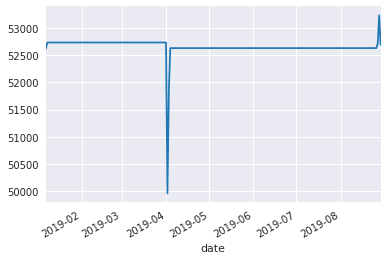

In [538]:
Risk.assets.plot()

In [480]:
Risk.message

{'account_cookie': 'ERICCAPTITAL',
 'alpha': 4.85,
 'annualize_return': 4.54,
 'assets': [49988.10275, 52714.102750000005, 52709.1365],
 'benchmark_assets': [50336.15019016421, 50146.645355614986],
 'benchmark_code': '000300',
 'beta': 1.0,
 'bm_annualizereturn': -0.31,
 'bm_profit': 0.0,
 'init_cash': '50000.00',
 'ir': 7.8275862068965525,
 'last_assets': '52709.14',
 'max_dropback': 0.0,
 'portfolio_cookie': 'eric',
 'profit': 0.05,
 'profit_money': 2709.14,
 'sharpe': 7.74,
 'time_gap': 3,
 'timeindex': ['2019-08-26', '2019-08-28'],
 'total_commission': -24.49,
 'total_tax': -50.37,
 'totaltimeindex': ['2019-08-26', '2019-08-27', '2019-08-28'],
 'user_cookie': 'eric',
 'volatility': 0.58}

In [424]:
Account.daily_hold.index.levels[0]

DatetimeIndex(['2019-08-26', '2019-08-27', '2019-08-28'], dtype='datetime64[ns]', name='date', freq=None)

In [425]:
Risk.market_value.sum(axis=1)

date        account_cookie
2019-08-26  ERICCAPTITAL      47589.0
2019-08-27  ERICCAPTITAL      50315.0
2019-08-28  ERICCAPTITAL          0.0
dtype: float64

In [426]:
Risk.profit_construct

{'total_buyandsell': 2784.0,
 'total_commission': -24.49,
 'total_profit': 2709.14,
 'total_tax': -50.37}

In [481]:
Performance=QA.QA_Performance(Account)

In [482]:
Performance.pnl_fifo

,sell_date,buy_date,amount,sell_price,buy_price,pnl_ratio,pnl_money,hold_gap
code,,,,,,,,
601069,2019-08-28,2019-08-26,2900,17.37,16.41,0.0585,2784.0,2 days


In [129]:
Account.save()
Risk.save()

In [483]:
account_info=QA.QA_fetch_account({'account_cookie':'JCSC_EXAMPLE'})
account_info

[{'account_cookie': 'JCSC_EXAMPLE',
  'allow_sellopen': False,
  'allow_t0': False,
  'broker': 'backtest',
  'cash': [50000,
   22903.2275,
   49000.565,
   20443.4275,
   46291.07750000001,
   20984.752500000006,
   44774.9775,
   19908.7625,
   43798.862499999996,
   18772.607499999995,
   42942.3575,
   21306.949999999997,
   41321.899999999994,
   20706.747499999994],
  'commission_coeff': 0.00025,
  'current_time': 'None',
  'end_date': '2019-08-15',
  'frequence': 'day',
  'history': [['2019-04-19 00:00:00',
    '000977',
    27.09,
    1000,
    22903.2275,
    'Order_SlcaN4Ht',
    'Order_SlcaN4Ht',
    'Trade_TVYjBzP8',
    'JCSC_EXAMPLE',
    6.7725,
    0,
    None,
    0],
   ['2019-04-23 00:00:00',
    '000977',
    26.13,
    -1000,
    49000.565,
    'Order_dJDw907l',
    'Order_dJDw907l',
    'Trade_Rd29H4NM',
    'JCSC_EXAMPLE',
    6.5325,
    26.13,
    None,
    0],
   ['2019-04-24 00:00:00',
    '000977',
    28.55,
    1000,
    20443.4275,
    'Order_AdCknOBI',


In [ ]:
stocklist = 